## 5 Convolutional Sequence to Sequence Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

import warnings
warnings.simplefilter('ignore')

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import spacy.cli 
spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
# Creating tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens)
    
    :param text: the german sentence
    """
    
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    
    :param text: the english sentence
    """
    
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [7]:
# Download and load the train, valid and test data

train_data, valid_data, test_data = Multi30k.splits(
    exts = ('.de', '.en'),
    fields = (SRC, TRG)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 572kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 174kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [8]:
# Verifying

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(vars(train_data.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [9]:
# building vocabulary
# min_freq => min threshold to include the word in the vocab

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [10]:
# Unique Tokens
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


## Creating Iterators

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x : len(x.src),
    device = device
)

## Building the Model

### Encoder

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device, max_length = 100):
        """
        :param input_dim: It is the size/dimensionality of the one-hot vectors that will be input to the encoder. 
                        This is equal to the input (source) vocabulary size.
        :param emb_dim: It is the dimensionality of the embedding layer. 
                        This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param enc_hid_dim: It is the dimensionality of the hidden state of the encoder.
        :param n_layers: The number of layers to be used in CNN.
        :param kernel_size: The kernel size to be used during Convolution
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: gpu or cpu
        :param max_length: The positional embedding is initialized to have this much size of the vocabulary.
                        i.e, it can handle sequences up to `max_length` elements long.
                        Implying, we can retain the positional information for sequences upto max_length.
        """
        
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        # Scale ??
        # It ensures that the variance throughout the network does not change dramatically.
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(in_channels = hid_dim,
                          out_channels = 2 * hid_dim,
                          kernel_size = kernel_size,
                          padding = (kernel_size - 1) // 2
                         )
                
                for _ in range(n_layers)
            ]
        )
        # Notice that output after each convolution will have the same dimension!!
        # Why? due to padding
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        # src.shape => (batch_size, src_len)
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [[0, 1, 2, 3, ..., (src_len - 1)], ... , batch_size times]
        # pos.shape => (batch_size, src_len)
        
        # embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        # tok_embedded.shape = pos_embedded.shape => (batch_size, src_len, emb_dim)
        
        # Combine Embeddings by `Elementwise Summing`
        embedded = self.dropout(tok_embedded + pos_embedded)
        # embedded.shape => (batch_size, src_len, emb_dim)
        
        # pass embedded through the linear layer to convert from emb_dim to hid_dim
        conv_input = self.emb2hid(embedded)
        # conv_input.shape => (batch_size, src_len, hid_dim)
        
        # permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1)
        # conv_input.shape => (batch_size, hid_dim, src_len)
        
        # Begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
            
            # pass through convolutional layer
            conved = conv(self.dropout(conv_input))
            # conved.shape => (batch_size, 2 * hid_dim, src_len)
            
            # Why we doubled the hid_dim through convolution?
            # Because, we have to use the GLU activation function, which halves the hiddden dimension.
            
            # pass through GLU (GATED LINEAR UNITS) activation function
            conved = F.glu(conved, dim = 1)
            # conved.shape => (batch_size, hid_dim, src_len)
            
            # Apply residual connection
            conved = (conved + conv_input) * self.scale
            # conved.shape => (batch_size, hid_dim, src_len)
            
            # Set conv_input to conved for next loop iteration
            conv_input = conved
            
        # ... End convolutional blocks
        
        # permute and convert back to emb_dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        # conved.shape => (batch_size, src_len, hid_dim)
        
        # Elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        # combined.shape => (batch_size, src_len, emb_dim)
        
        return conved, combined

### Decoder

In [14]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, trg_pad_idx, device, max_length = 100):
        """
        :param output_dim: It is the size/dimensionality of the one-hot vectors that will be the output of the decoder.
                        This is equal to the output (target) vocabulary size.
        :param emb_dim: It is the dimensionality of the embedding layer. 
                        This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param hid_dim: It is the dimensionality of the hidden state of the decoder
        :param n_layers: The number of layers to be used in CNN.
        :param kernel_size: The kernel size to be used during Convolution
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: gpu or cpu
        :param trg_pad_idx: the <pad> index for pre-padding the sentence.
                        Why pre-padded, why not padding equally on both sides?
                        It ensures that we don't see the word we want to predict, otherwise, during convolution,
                        the word to be predicted would be included in the window itself, resulting in the model to
                        learn just copying the last word in the window, it sees, as the prediction!!
        :param max_length: The positional embedding is initialized to have this much size of the vocabulary.
                        i.e, it can handle sequences up to `max_length` elements long.
                        Implying, we can retain the positional information for sequences upto max_length.
        """
        
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(in_channels = hid_dim,
                          out_channels = 2 * hid_dim,
                          kernel_size = kernel_size,
                         )
                for _ in range(n_layers)
            ]
        )
        
        self.dropout = nn.Dropout(dropout)
        
        
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        # embedded.shape => (batch_size, trg_len, emb_dim)
        # conved.shape => (batch_size, hid_dim, trg_len)
        # encoder_conved.shape = encoder_combined.shape => (batch_size, src_len, emb_dim)
        
        # permute and convert back to emb_dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        # conved_emb.shape => (batch_size, trg_len, emb_dim)
        
        combined = (conved_emb + embedded) * self.scale
        # combined.shape => (batch_size, trg_len, emb_dim)
        
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        # energy.shape => (batch_size, trg_len, src_len)
        
        attention = F.softmax(energy, dim = 2)
        # attention.shape => (batch_size, trg_len, src_len)
        
        attention_encoding = torch.matmul(attention, encoder_combined)
        # attention_encoding.shape => (batch_size, trg_len, emb_dim)
        
        # convert from emb_dim to hid_dim
        attention_encoding = self.attn_emb2hid(attention_encoding)
        # attention_encoding.shape => (batch_size, trg_len, hid_dim)
        
        # apply residual connection
        attention_combined = (conved + attention_encoding.permute(0, 2, 1)) * self.scale
        # attention_combined.shape => (batch_size, hid_dim, trg_len)
        
        return attention, attention_combined
    
    
    def forward(self, trg, encoder_conved, encoder_combined):
        
        # trg.shape => (batch_size, trg_len)
        # encoder_conved.shape = encoder_combined.shape => (batch_size, src_len, emb_dim)
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        # create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos.shape => (batch_size, trg_len)
        
        # embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        # tok_embedded.shape = pos_embedded.shape => (batch_size, trg_len, emb_dim)
        
        # combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        # embedded.shape => (batch_size, trg_len, emb_dim)
        
        # pass embedded through linear layer to go through emb_dim to hid_dim
        conv_input = self.emb2hid(embedded)
        # conv_input.shape => (batch_size, trg_len, hid_dim)
        
        # permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1)
        # conv_input.shape => (batch_size, hid_dim, trg_len)
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
            
            # apply dropout
            conv_input = self.dropout(conv_input)
            
            # need to pad so decoder can't cheat
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            # padded_conv_input.shape => (batch_size, hid_dim, trg_len + kernel_size - 1)
            
            # pass through the convolutional layer
            conved = conv(padded_conv_input)
            # conved.shape => (batch_size, hid_dim * 2, trg_len)
            
            # pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            # conved.shape => (batch_size, hid_dim, trg_len)
            
            # calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved,
                                                         encoder_combined)
            # attention.shape => (batch_size, trg_len, src_len)
            
            # apply residual connection
            conved = (conved + conv_input) * self.scale
            # conved.shape => (batch_size, hid_dim, trg_len)
            
            # set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
        # conved.shape => (batch_size, trg_len, emb_dim)
        
        output = self.fc_out(self.dropout(conved))
        # output.shape => (batch_size, trg_len, output_dim)
        
        return output, attention

### Seq2Seq Model

In [15]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        """
        :param src: the source sentence sequence
                    src.shape => (batch_size, src_len)
        :param trg: the target senetence sequence
                    trg.shape => (batch_size, trg_len - 1) 
                    b/c <eos> token sliced off the end
        """
        
        # calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        # encoder_conved is output form final encoder conv. block
        # encoder_combined is encoder_conved plus (elementwise) src embedding + positional embedding
        encoder_conved, encoder_combined = self.encoder(src)
        # encoder_conved.shape => (batch_size, src_len, emb_dim)
        # encoder_combined => (batch_size, src_len, emb_dim)
        
        # calculate predictions of next words
        # output is a batch of predictions for each word in the trg sentence
        # attention is a batch of attention scores across the src sentence for 
        # each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        # output.shape => (batch_size, trg_len - 1, output_dim)
        # attention.shape => (batch_size, trg_len - 1, src_len)
        
        return output, attention

## Training the Seq2Seq Model

### Init the Model

In [16]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,173 trainable parameters


In [18]:
# define the optimizer
optimizer = optim.Adam(model.parameters())

In [19]:
# loss function
# NOTE: Our loss function calculates the average loss per token, 
# however by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

## Training Function

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:, :-1])
        # <eos> is to be learned!
        # trg      = [sos, x1, x2, x3, eos]
        # trg[:-1] = [sos, x1, x2, x3]
        # output   = [y1, y2, y3, eos]
        # trg[1:]  = [x1, x2, x3, eos]
        
        # output.shape => (batch_size, trg_len - 1, output_dim)
        # trg.shape => (batch_size, trg_len)
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        # output.shape => (batch_size * trg_len - 1, output_dim)
        
        trg = trg[:, 1:].contiguous().view(-1)
        # trg.shape => (batch_size * trg_len - 1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
        

## Evaluate Function

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output, _ = model(src, trg[:, :-1])
            # output.shape => (batch_size, trg_len - 1, output_dim)
            # trg.shape => (batch_size, trg_len)

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # output.shape => (batch_size * trg_len - 1, output_dim)

            trg = trg[:, 1:].contiguous().view(-1)
            # trg.shape => (batch_size * trg_len - 1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)
        

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
N_EPOCHS = 15
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 34s
	Train Loss: 4.306 | Train PPL:  74.108
	 Val. Loss: 2.945 |  Val. PPL:  19.016
Epoch: 02 | Time: 0m 28s
	Train Loss: 2.981 | Train PPL:  19.716
	 Val. Loss: 2.348 |  Val. PPL:  10.464
Epoch: 03 | Time: 0m 28s
	Train Loss: 2.554 | Train PPL:  12.854
	 Val. Loss: 2.101 |  Val. PPL:   8.172
Epoch: 04 | Time: 0m 28s
	Train Loss: 2.321 | Train PPL:  10.188
	 Val. Loss: 1.980 |  Val. PPL:   7.240
Epoch: 05 | Time: 0m 28s
	Train Loss: 2.170 | Train PPL:   8.762
	 Val. Loss: 1.893 |  Val. PPL:   6.636
Epoch: 06 | Time: 0m 28s
	Train Loss: 2.058 | Train PPL:   7.833
	 Val. Loss: 1.839 |  Val. PPL:   6.288
Epoch: 07 | Time: 0m 28s
	Train Loss: 1.970 | Train PPL:   7.174
	 Val. Loss: 1.798 |  Val. PPL:   6.039
Epoch: 08 | Time: 0m 28s
	Train Loss: 1.900 | Train PPL:   6.683
	 Val. Loss: 1.771 |  Val. PPL:   5.877
Epoch: 09 | Time: 0m 28s
	Train Loss: 1.836 | Train PPL:   6.274
	 Val. Loss: 1.744 |  Val. PPL:   5.722
Epoch: 10 | Time: 0m 28s
	Train Loss: 1.784 | Train PPL

In [24]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.751 | Test PPL:   5.760 |


## Inference

In [25]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    """
        translate the given `sentence` in src lang to the trg lang.
    
    :param sentence: the sentence string in src lang
    :param src_field: the SRC Field object
    :param trg_field: the TRG Field object
    :param model: the Seq2Seq model
    :param device: gpu or cpu
    :param max_len: the maximum length permitted for the trg sentence
    """
    
    model.eval()
    
    # Sentence --> tokens
    if isinstance(sentence, str):
        nlp = spcay.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
        
    else:
        tokens = [token.lower() for token in sentence]

    # adding <sos> and <eos>
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    # Tokens --> list of indices, acc. to SRC vocab
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    # src_tensor.shape => (1, src_len), where 1 = batch_size
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):
        
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        with torch.no_grad():
            
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
            
            pred_token = output.argmax(2)[:, -1].item()
            # output.shape => (batch_size, trg_len so far = `i + 1` , hid_dim)
            # argmax on 2nd dimension
            # o/p = max prob. token for each token
            # i.e j = 0th pos to .... to j = ith pos
            # but we just want the last token, to feed in, for the next iteration
            
            trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [26]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [27]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [28]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'climbing', 'in', 'a', 'playhouse', '.', '<eos>']


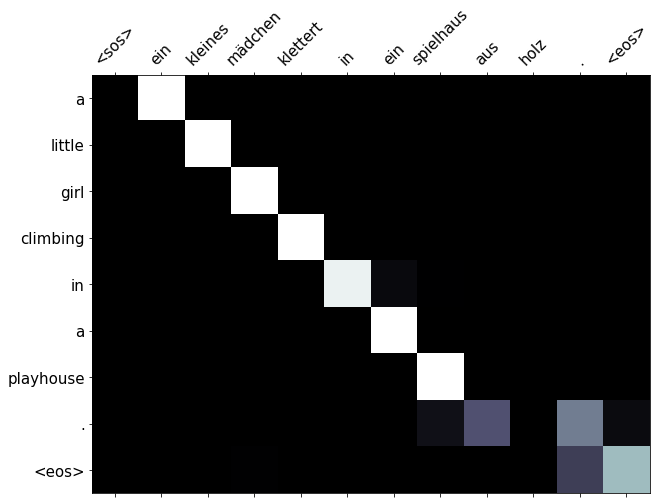

In [29]:
display_attention(src, translation, attention)

In [30]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


In [31]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'with', 'headphones', 'sits', 'on', 'the', 'shoulders', 'of', 'a', 'woman', '.', '<eos>']


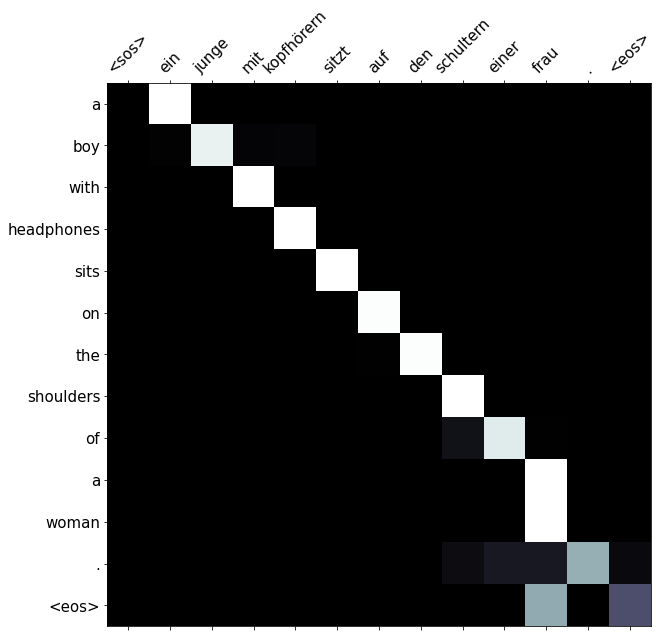

In [32]:
display_attention(src, translation, attention)

## BLEU Score

In [33]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [34]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.41
